*Authors: Alejandro Delgado and Pablo Fernández*. 

# 0. Libraries

In [316]:
# Pandas tools
import pandas as pd
import pandas as pd
import pandas.io.sql as sqlio
from pandas import DataFrame

# Database-related tools
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.orm import sessionmaker

# Other utilities
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Connection to the databases (including the data warehouse) and the .csv

## 1.1. External data sources

Connection or extraction to the provided data sources. 

In [ ]:
# Connection to the AIMS and AMOS databases
if 'aims' in globals():
  aims.close()
aims = psycopg2.connect(database='aims', user='bse_airlines', host='dtim.essi.upc.edu', password='', options='-c search_path=bda-aims')
cursor_aims = aims.cursor()
if 'amos' in globals():
  amos.close()
amos = psycopg2.connect(database='amos', user='bse_airlines', host='dtim.essi.upc.edu', password='', options='-c search_path=bda-amos')
cursor_amos = amos.cursor()

# Reading the .csv (must ensure that it is in the same working directory as this notebook)
df_manufacturer_lookup = pd.read_csv('aircraft-manufaturerinfo-lookup.csv')

## 1.2. Creation and connection to the data warehouse

### UML of the data warehouse (ROLAP)

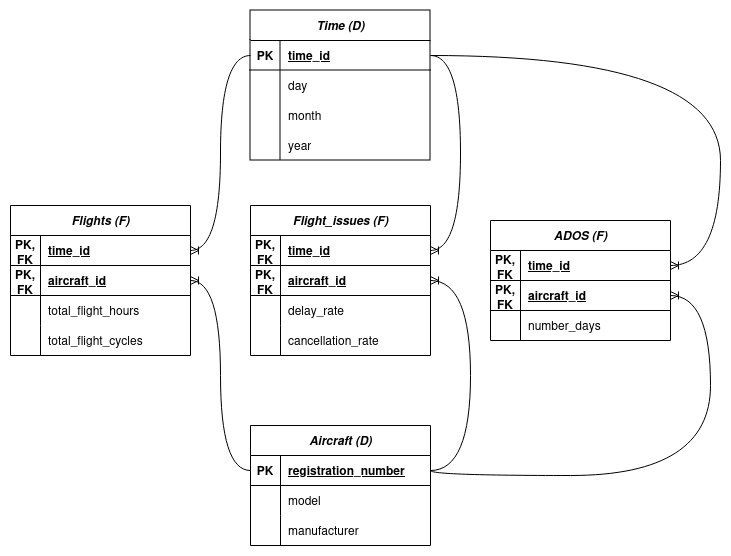

As shown in the previous figure, our data warehouse consists on 3 fact tables and 2 shared dimension tables:
- ***Time (D)*** is a dimension table which contains a unique time identifier, the day (in some cases it is null, as some measures are not computed over days but only over months and years), the month and the year.
- ***Aircraft (D)*** is the second dimension table, and includes the registration number of the aircraft (which is the primary key) as well as the model and the manufacturer (both are included because in some cases the model name is the same for two different manufacturers).
- ***Flights (F)*** contains the measures of flight hours and flight cycles, grouped by the *time_id* and *aircraft_id*.
- ***Flight_issues (F)*** contains the measures of delay rate and cancellation rate, grouped by the *time_id* and *aircraft_id*.
- ***ADOS (F)*** contains the number of days an aircraft has been out of service, grouped by the *time_id* and *aircraft_id*.

### Creation of the database, execution of the SQL scripts and connection to the data warehouse

Creation of the data warehouse (ROLAP) using the SQL scripts in the `tables_dw` folder. Note that the code below creates a new database for the specified user.

Functions to create the database and the tables of the data warehouse:

In [ ]:
# Database connection parameters
DB_NAME = "lab3_dw_delgado_fernandez"
DB_USER = "postgres"    # Adjust as necessary
DB_PASSWORD = ""    # Adjust as necessary
DB_HOST = "localhost"    # Adjust as necessary
DB_PORT = "5432"    # Adjust as necessary

# Function to drop and recreate the database
def recreate_database():
    try:
        # Connect to the default 'postgres' database
        connection = psycopg2.connect(
            dbname="postgres", 
            user=DB_USER, 
            password=DB_PASSWORD, 
            host=DB_HOST, 
            port=DB_PORT
        )
        connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cursor = connection.cursor()

        # Drop the database if it exists
        cursor.execute(f"SELECT pg_terminate_backend(pg_stat_activity.pid) "
                       f"FROM pg_stat_activity WHERE pg_stat_activity.datname = '{DB_NAME}';")
        cursor.execute(f"DROP DATABASE IF EXISTS {DB_NAME};")
        print(f"Database '{DB_NAME}' dropped successfully (if it existed).")

        # Create the new database
        cursor.execute(f"CREATE DATABASE {DB_NAME};")
        print(f"Database '{DB_NAME}' created successfully.")

        # Close the connection
        cursor.close()
        connection.close()
    except Exception as e:
        print(f"Error recreating database: {e}")

# Function to execute an SQL file
def execute_sql_file(file_path, engine):
    with open(file_path, 'r') as file:
        sql_code = file.read()
        with engine.connect() as connection:
            try:
                connection.execute(text(sql_code))
                connection.commit()  # Commit the transaction
                print(f"Executed SQL file: {file_path}")
            except Exception as e:
                print(f"Error executing {file_path}: {e}")

# Function to drop all tables in the database
def drop_all_tables(engine):
    inspector = inspect(engine)
    with engine.connect() as connection:
        transaction = connection.begin()
        try:
            for table_name in inspector.get_table_names():
                connection.execute(text(f"DROP TABLE IF EXISTS {table_name} CASCADE"))
            transaction.commit()
            print("Dropped all existing tables.")
        except Exception as e:
            transaction.rollback()
            print(f"Error dropping tables: {e}")

# Function to create tables
def create_tables(engine):
    directory = 'tables_dw'  # Directory containing SQL files
    files_path = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.sql')])

    for file_path in files_path:
        execute_sql_file(file_path, engine)

Executing the functions for creating the database and the tables for the data warehouse:

In [319]:
if __name__ == "__main__":
    # Step 1: Recreate the database (i.e., drop preexisting DB with the same name 
    # and create a new one)
    recreate_database()

    # Step 2: Connect to the newly created database
    DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(DATABASE_URL)

    # Step 3: Drop all tables and create new ones
    drop_all_tables(engine)
    create_tables(engine)

    # Step 4: Close connection to the database
    engine.dispose()
    print("Database connection closed successfully.")

Database 'lab3_dw_delgado_fernandez' dropped successfully (if it existed).
Database 'lab3_dw_delgado_fernandez' created successfully.
Dropped all existing tables.
Executed SQL file: tables_dw/01_Aircraft.sql
Executed SQL file: tables_dw/02_Time.sql
Executed SQL file: tables_dw/03_Flights.sql
Executed SQL file: tables_dw/04_Flight_Issues.sql
Executed SQL file: tables_dw/05_ADOS.sql
Database connection closed successfully.


In [320]:
# Connect to the newly created database through psycopg2 (for consistency)
if DB_NAME in globals():
    DB_NAME.close()
dw = psycopg2.connect(database=DB_NAME, user=DB_USER, host=DB_HOST, password=DB_PASSWORD)
# Create a cursor
cursor_dw = dw.cursor()

# 2. ETL process

## 2.1. Extracting the necessary data from AIMS, AMOS and the aircraft manufacturer lookup (.csv)

For answering the user analytical requirements *R1* and *R2* and filling the data warehouse with meaningful data, we have found it relevant to extract the following data from the data inputs:
- First, the actual times of departure and arrival of the flights (*actualDeparture* and *actualArrival*, from the relation *Flights* of the database AIMS). We will use these timestamps to extract the day, month and year of a certain flight. In turn, this information will then be used for knowing the total flight hours and cycles per aircraft, day, month and year. We will check that there were no flights that happened at the same time as maintenance slots (which would be inconsistent).
- Second, the *aircraftRegistration* number from the *Flights* relation of the database AIMS.
- Third, from the csv we will extract the model and manufacturer for each registration number.
- Fourth, for the requirement R2, we will extract the scheduled time for a flight, which is in the relation *Slots* in the database AIMS (but since *Flights* inherits from *Slots*, *Flights* will suffice for the facts "delay rate" and "cancellation rate").
- Fifth, we will use the boolean *cancelled* and the *delayCode* ("IATA code" of the delay) for computing the rates of flights that have been either cancelled or delayed, respectively. Basically, null delay codes are flights which have operated on schedule, while those with a non-null delay codes have been delayed ([general reference of IATA delay codes](https://en.wikipedia.org/wiki/IATA_delay_codes), [list of codes](https://ansperformance.eu/library/iata-delay-codes.pdf)).
- Sixth, the times of maintenance events, which will be used to assess whether it is good data for computing the aircraft days out of service.

### a. AIMS

In [321]:
# Extract fields of interest from the Flights table, which inherits from Slots - AIMS

Q_flights = "SELECT aircraftregistration, flightid, scheduleddeparture, scheduledarrival, actualdeparture, actualarrival, cancelled, delaycode FROM Flights;"

df_flights = sqlio.read_sql_query(Q_flights, aims)

df_flights.head(10)

aircraftregistration                    flightid         scheduleddeparture  \
0               XY-RJL  230803-NRN-JMK-9129-XY-RJL 2023-08-03 11:03:03.875940   
1               XY-OZE  230726-HAU-SAW-9867-XY-OZE 2023-07-26 14:50:15.569812   
2               XY-SJZ  231120-HER-VAA-6975-XY-SJZ 2023-11-20 09:01:04.308766   
3               XY-OXK  230613-VNO-EGC-9468-XY-OXK 2023-06-13 09:55:02.480695   
4               XY-DGU  230312-BLL-BVA-9815-XY-DGU 2023-03-12 00:41:45.198279   
5               XY-CMS  230927-vKo-lUg-5629-XY-CMS 2023-09-27 04:16:33.946201   
6               XY-RJM  230106-ESB-SXF-1266-XY-RJM 2023-01-06 21:23:48.860304   
7               XY-LKU  230730-BHX-BDS-3846-XY-LKU 2023-07-30 13:40:52.793055   
8               XY-CRS  230103-GVA-GDN-4559-XY-CRS 2023-01-03 03:52:12.278595   
9               XY-IVJ  230125-Gva-led-1268-XY-IVJ 2023-01-25 16:50:39.680743   

            scheduledarrival actualdeparture actualarrival  cancelled  \
0 2023-08-03 14:03:03.875940             NaT           NaT       True   
1 2023-07-26 15:50:15.569812             NaT           NaT       True   
2 2023-11-20 13:01:04.308766             NaT           NaT       True   
3 2023-06-13 11:55:02.480695             NaT           NaT       True   
4 2023-03-12 03:41:45.198279             NaT           NaT       True   
5 2023-09-27 05:16:33.946201             NaT           NaT       True   
6 2023-01-07 02:23:48.860304             NaT           NaT       True   
7 2023-07-30 18:40:52.793055             NaT           NaT       True   
8 2023-01-03 04:52:12.278595             NaT           NaT       True   
9 2023-01-25 18:50:39.680743             NaT           NaT       True   

  delaycode  
0      None  
1      None  
2      None  
3      None  
4      None  
5      None  
6      None  
7      None  
8      None  
9      None

In [322]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151833 entries, 0 to 151832
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aircraftregistration  151833 non-null  object        
 1   flightid              151833 non-null  object        
 2   scheduleddeparture    151833 non-null  datetime64[ns]
 3   scheduledarrival      151833 non-null  datetime64[ns]
 4   actualdeparture       141792 non-null  datetime64[ns]
 5   actualarrival         141792 non-null  datetime64[ns]
 6   cancelled             151833 non-null  bool          
 7   delaycode             14166 non-null   object        
dtypes: bool(1), datetime64[ns](4), object(3)
memory usage: 8.3+ MB


In [323]:
# Extract fields of interest from the Maintenance table, which inherits from Slots - AIMS
# This can be useful for checking consistency and duplicities

Q_maint_aims = "SELECT aircraftregistration, scheduleddeparture, scheduledarrival FROM Maintenance;"

df_maint_aims = sqlio.read_sql_query(Q_maint_aims, aims)

df_maint_aims.head(10)

aircraftregistration         scheduleddeparture           scheduledarrival
0               XY-AAB 2023-01-01 12:16:40.291989 2023-01-01 15:16:40.291989
1               XY-AAB 2023-01-01 18:04:56.231015 2023-01-01 19:04:56.231015
2               XY-AAB 2023-01-03 22:24:03.213203 2023-01-03 23:24:03.213203
3               XY-AAB 2023-01-04 11:34:31.530886 2023-01-04 11:34:31.530886
4               XY-AAB 2023-01-04 17:21:00.599109 2023-01-04 19:21:00.599109
5               XY-AAB 2023-01-05 09:21:57.443837 2023-01-05 10:21:57.443837
6               XY-AAB 2023-01-07 11:48:20.469456 2023-01-07 15:48:20.469456
7               XY-AAB 2023-01-09 06:51:42.989543 2023-01-09 08:51:42.989543
8               XY-AAB 2023-01-11 18:41:10.390991 2023-01-11 20:41:10.390991
9               XY-AAB 2023-01-13 09:07:12.945785 2023-01-13 12:07:12.945785

In [324]:
df_maint_aims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74743 entries, 0 to 74742
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   aircraftregistration  74743 non-null  object        
 1   scheduleddeparture    74743 non-null  datetime64[ns]
 2   scheduledarrival      74743 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 1.7+ MB


### b. AMOS

In [325]:
# Extract fields of interest from the Maintenance table - AMOS
# This can be useful for checking consistency and duplicities

Q_maint_ev = "SELECT maintenanceid, aircraftregistration, starttime, duration FROM MaintenanceEvents;"

df_maint_ev = sqlio.read_sql_query(Q_maint_ev, amos)

df_maint_ev.head(10)

maintenanceid aircraftregistration                  starttime  \
0          24167               XY-AAB 2023-01-01 12:16:40.291989   
1          24168               XY-AAB 2023-01-01 18:04:56.231015   
2          24169               XY-AAB 2023-01-03 22:24:03.213203   
3          24170               XY-AAB 2023-01-04 11:34:31.530886   
4          24171               XY-AAB 2023-01-04 17:21:00.599109   
5          24172               XY-AAB 2023-01-05 09:21:57.443837   
6          24173               XY-AAB 2023-01-07 11:48:20.469456   
7          24174               XY-AAB 2023-01-09 06:51:42.989543   
8          24175               XY-AAB 2023-01-11 18:41:10.390991   
9          24176               XY-AAB 2023-01-13 09:07:12.945785   

         duration  
0 0 days 03:00:00  
1 0 days 01:00:00  
2 0 days 01:00:00  
3 0 days 00:00:00  
4 0 days 02:00:00  
5 0 days 01:00:00  
6 0 days 04:00:00  
7 0 days 02:00:00  
8 0 days 02:00:00  
9 0 days 03:00:00

In [326]:
df_maint_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98909 entries, 0 to 98908
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   maintenanceid         98909 non-null  int64          
 1   aircraftregistration  98909 non-null  object         
 2   starttime             98909 non-null  datetime64[ns] 
 3   duration              98909 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), timedelta64[ns](1)
memory usage: 3.0+ MB


### c. Aircraft Manufacturer Lookup (`.csv`)

In [327]:
df_manufacturer_lookup = pd.read_csv('aircraft-manufaturerinfo-lookup.csv')

df_manufacturer_lookup.drop(columns = ['manufacturer_serial_number'], inplace = True)

df_manufacturer_lookup.head()

aircraft_reg_code aircraft_model aircraft_manufacturer
0            XY-ZCK            777                Airbus
1            XY-UWV            777                Airbus
2            XY-HWJ            747                Airbus
3            XY-NIP            747                Boeing
4            XY-CMS           A319                Airbus

## 2.2. Data cleaning

### a. Removing duplicates
In this section, we check, separately for each extracted dataframe, whether there are unwanted duplicates in the data.

In [328]:
print(f"Number of duplicate flights: {len(df_flights) - df_flights['flightid'].nunique()}")

Number of duplicate flights: 0


In [329]:
print(f"Number of duplicate maintenance events: {len(df_maint_ev) - df_maint_ev['maintenanceid'].nunique()}")

Number of duplicate maintenance events: 0


In [330]:
print(f"Number of duplicate aircrafts: {len(df_manufacturer_lookup) - df_manufacturer_lookup['aircraft_reg_code'].nunique()}")

Number of duplicate aircrafts: 0


### b. Removing or imputing (non-desired) nulls
In this section, we check the consistency of the existing null values in the instances of the database and assess its treatment.

In [331]:
def check_nulls(df):
    # Count of null values per column
    df_tr_na = df.isnull().sum()
    # Filter only columns with missing values
    missing_values_tr = df_tr_na[df_tr_na > 0]
    # Compute percentage of missing values
    missing_values_percentage = (missing_values_tr / len(df)) * 100
    # Display the result
    print("Columns with missing values:")
    print(missing_values_tr)
    print("\nPercentage of missing values:")
    print(missing_values_percentage)

In [332]:
check_nulls(df_flights)

Columns with missing values:
actualdeparture     10041
actualarrival       10041
delaycode          137667
dtype: int64

Percentage of missing values:
actualdeparture     6.613187
actualarrival       6.613187
delaycode          90.670012
dtype: float64


In the flights table, there are missing values in the actual departure and arrival times (which is consistent with the fact that some flights may not have happened yet) and in the delay code (which is consistent as well for flights that have not been delayed). Therefore, there is no need to remove or to impute nulls.

In [333]:
check_nulls(df_maint_ev)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


In [334]:
check_nulls(df_manufacturer_lookup)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


### c. Checking domain constraints
In this section, we check some domain-specific constraints that may introduce a bias in the user analytical requirements. Specifically, we check that:
1. Scheduled flight departure time is always before the scheduled flight arrival time.
2. Duration of each maintenance event is always non-negative.
3. Aircrafts that have been assigned to flights are all registered (i.e., are in the lookup table).
4. The same aircraft is not assigned to a flight and to maintenance at the same time.
5. Flights that have been cancelled do not have an actual departure and arrival time.
6. Flights that have been delayed have the same or a future actual departure time from the scheduled time.

#### 1. Scheduled flight departure time is always before the scheduled flight arrival time.

In [335]:
# Time delta for the schedule
df_flights['diff_scheduled_arr-dep'] = df_flights['scheduledarrival'] - df_flights['scheduleddeparture']
# Time delta for the actual departure and arrival
df_flights['diff_actual_arr-dep'] = df_flights['actualarrival'] - df_flights['actualdeparture']
# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

aircraftregistration                    flightid  \
94884                XY-OYK  231031-LbA-tFn-1671-XY-OYK   
108000               XY-RQO  230311-MPL-TBS-8361-XY-RQO   
107976               XY-RQO  230217-bmA-ztH-4942-XY-RQO   
6872                 XY-TIH  230801-FNc-Cwl-9351-XY-TIH   
38290                XY-EWI  230711-ISt-tSe-9526-XY-EWI   

               scheduleddeparture           scheduledarrival  \
94884  2023-10-31 14:25:10.652754 2023-10-31 14:25:10.652754   
108000 2023-03-11 04:39:03.225015 2023-03-11 04:39:03.225015   
107976 2023-02-17 09:31:19.357030 2023-02-17 09:31:19.357030   
6872   2023-08-01 20:52:12.179444 2023-08-01 20:52:12.179444   
38290  2023-07-11 00:05:11.314626 2023-07-11 00:05:11.314626   

                  actualdeparture              actualarrival  cancelled  \
94884  2023-10-31 14:39:10.652754 2023-10-31 14:39:10.652754      False   
108000 2023-03-11 04:44:03.225015 2023-03-11 04:44:03.225015      False   
107976 2023-02-17 09:39:19.357030 2023-02-17 09:39:19.357030      False   
6872                          NaT                        NaT       True   
38290  2023-07-11 00:14:11.314626 2023-07-11 00:14:11.314626      False   

       delaycode diff_scheduled_arr-dep diff_actual_arr-dep  
94884       None                 0 days              0 days  
108000      None                 0 days              0 days  
107976      None                 0 days              0 days  
6872        None                 0 days                 NaT  
38290       None                 0 days              0 days

It seems that there are some flights which have not been cancelled or delayed for which the scheduled departure time coincides with the scheduled arrival time, and the same happens for the actual times: for now, we will flag those flights with an additional column, for facilitating the possibility of dropping in the futurer those instances. 

In [336]:
# Inconsistent schedule
df_flights['inconsistent_schedule'] = (
    (df_flights['diff_scheduled_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Inconsistent actual flights
df_flights['inconsistent_actual'] = (
    (df_flights['diff_actual_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

aircraftregistration                    flightid  \
94884                XY-OYK  231031-LbA-tFn-1671-XY-OYK   
108000               XY-RQO  230311-MPL-TBS-8361-XY-RQO   
107976               XY-RQO  230217-bmA-ztH-4942-XY-RQO   
6872                 XY-TIH  230801-FNc-Cwl-9351-XY-TIH   
38290                XY-EWI  230711-ISt-tSe-9526-XY-EWI   

               scheduleddeparture           scheduledarrival  \
94884  2023-10-31 14:25:10.652754 2023-10-31 14:25:10.652754   
108000 2023-03-11 04:39:03.225015 2023-03-11 04:39:03.225015   
107976 2023-02-17 09:31:19.357030 2023-02-17 09:31:19.357030   
6872   2023-08-01 20:52:12.179444 2023-08-01 20:52:12.179444   
38290  2023-07-11 00:05:11.314626 2023-07-11 00:05:11.314626   

                  actualdeparture              actualarrival  cancelled  \
94884  2023-10-31 14:39:10.652754 2023-10-31 14:39:10.652754      False   
108000 2023-03-11 04:44:03.225015 2023-03-11 04:44:03.225015      False   
107976 2023-02-17 09:39:19.357030 2023-02-17 09:39:19.357030      False   
6872                          NaT                        NaT       True   
38290  2023-07-11 00:14:11.314626 2023-07-11 00:14:11.314626      False   

       delaycode diff_scheduled_arr-dep diff_actual_arr-dep  \
94884       None                 0 days              0 days   
108000      None                 0 days              0 days   
107976      None                 0 days              0 days   
6872        None                 0 days                 NaT   
38290       None                 0 days              0 days   

        inconsistent_schedule  inconsistent_actual  
94884                    True                 True  
108000                   True                 True  
107976                   True                 True  
6872                    False                False  
38290                    True                 True

This result has the intended purpose: it flags with `True` those flights for which the scheduled or actual departure time matches the scheduled or actual arrival time, for flights that have *not* been cancelled. In the end, those flights should not be taken into account for computing the total flight hours, cycles and delay and cancellation rates. Below, we remove those flights with inconsistent actual flight times, which happen to remove as well all inconsistent scheduled flight times:

In [337]:
df_flights = df_flights[df_flights['inconsistent_actual'] != True]

print(f"Number of inconsistent schedules after removing the inconsistencies in actual times of flight: {len(df_flights[df_flights['inconsistent_schedule'] == True])}")

Number of inconsistent schedules after removing the inconsistencies in actual times of flight: 0


#### 2. Duration of each maintenance event is always non-negative

In [338]:
if len(df_maint_ev[df_maint_ev['duration'] < pd.Timedelta("0 days 00:00:00")]) > 0:
    print('There are maintenance events of negative duration, which should be removed.')
else:
    print('There are no negative maintenance event durations, so the data is (in this regard) consistent.')

There are no negative maintenance event durations, so the data is (in this regard) consistent.


#### 3. Aircrafts that have been assigned to flights are all registered

In [339]:
df_join = df_flights.merge(right = df_manufacturer_lookup, how = 'inner', left_on='aircraftregistration', right_on='aircraft_reg_code')

# Since we have done an inner join, if all the aircrafts that are assigned to flights
# are registered, the length of both data frames should be the same
if len(df_join) < len(df_flights):
    print('There are some non-registered aircrafts that are assigned to flights.')
else:
    print('All aircrafts assigned to flights are registered.')

# We delete the data frame that has been used for this check
del df_join

All aircrafts assigned to flights are registered.


#### 4. The same aircraft is not assigned to a flight and to maintenance at the same time
In this case, we can do 2 different checks: one for the *Maintenance* table, checking if there are Flights and Maintenances in conflict, and another for the *MaintenanceEvents* table.

In [340]:
# We merge the data frames, keeping only the observations which correspond to
# common aircrafts between both data frames
conflicts = pd.merge(
    left = df_flights,
    right = df_maint_aims,
    how = 'inner',
    on = "aircraftregistration",
    suffixes=("_flight", "_maintenance"),
)

# Check for schedule overlap
conflicts["overlap"] = (
    (conflicts["scheduleddeparture_flight"] < conflicts["scheduledarrival_maintenance"])
    & (conflicts["scheduledarrival_flight"] > conflicts["scheduleddeparture_maintenance"])
)

# Filter rows with overlaps: this should return some observations if there is an overlap. We
# filter out those flights that have been cancelled, since those won't cause an issue
conflicting_schedules = conflicts[(conflicts["overlap"] == True) & (conflicts['cancelled'] == False)]

if len(conflicting_schedules) == 0:
    print('There are no conflicts of aircrafts being assigned to (non-cancelled) flights and to maintenance at the same time.')
else:
    print('There are conflicts caused by some aircrafts being assigned to (non-cancelled) flights and to maintenance at the same time.')

del conflicts, conflicting_schedules

There are no conflicts of aircrafts being assigned to (non-cancelled) flights and to maintenance at the same time.


Now, we do the same check but for the maintenance events (the table in the AMOS database). In this case, we check for overlaps in the actual flight times since some maintenance events are performed in the middle of the schedule of a flight, which are directly related to the delay of that flight (i.e., if there is something in the engine that must be checked before the departure, that would create the need for a maintenance event and, consequently, a delay).

In [341]:
# We compute the end time of the maintenance event with the duration of it
df_maint_ev['endtime'] = df_maint_ev['starttime'] + df_maint_ev['duration']

# We merge the data frames, keeping only the observations which correspond to
# common aircrafts between both data frames
conflicts = pd.merge(
    left = df_flights,
    right = df_maint_ev,
    how = 'inner',
    on = "aircraftregistration",
    suffixes=("_flight", "_maintenance"),
)

# Check for the actual flight overlap
conflicts["overlap"] = (
    (conflicts["actualdeparture"] < conflicts["endtime"])
    & (conflicts["actualarrival"] > conflicts["starttime"])
)

# Filter rows with overlaps: this should return some observations if there is an overlap. We
# filter out those flights that have been cancelled, since those won't cause an issue
conflicting_schedules = conflicts[(conflicts["overlap"] == True) & (conflicts['cancelled'] == False)]

if len(conflicting_schedules) == 0:
    print('There are no conflicts caused by some aircrafts being in the middle of a flight and with maintenance events at the same time.')
else:
    print('There are conflicts caused by some aircrafts being in the middle of a flight and with maintenance events at the same time.')

There are conflicts caused by some aircrafts being in the middle of a flight and with maintenance events at the same time.


In [342]:
display(conflicting_schedules.head())
print(f'Number of aircrafts with conflicts caused by flights and maintenance events at the same time: {len(conflicting_schedules)}')

del conflicts, conflicting_schedules

aircraftregistration                    flightid  \
3160193               XY-AAB  230101-BRQ-FRA-6137-XY-AAB   
3169262               XY-AAB  230127-TZX-LTN-4388-XY-AAB   
3174672               XY-AAB  230210-TPS-PFO-2897-XY-AAB   
3176696               XY-AAB  230216-BIO-TZL-5886-XY-AAB   
3191398               XY-AAB  230320-DRS-SVO-4271-XY-AAB   

                scheduleddeparture           scheduledarrival  \
3160193 2023-01-01 06:30:11.353825 2023-01-01 10:30:11.353825   
3169262 2023-01-27 11:52:11.458435 2023-01-27 13:52:11.458435   
3174672 2023-02-10 22:22:10.678058 2023-02-10 23:22:10.678058   
3176696 2023-02-16 18:32:20.219401 2023-02-16 20:32:20.219401   
3191398 2023-03-20 00:58:20.254622 2023-03-20 03:58:20.254622   

                   actualdeparture              actualarrival  cancelled  \
3160193 2023-01-01 06:47:11.353825 2023-01-01 10:47:11.353825      False   
3169262 2023-01-27 12:06:11.458435 2023-01-27 14:06:11.458435      False   
3174672 2023-02-10 22:22:10.678058 2023-02-10 23:22:10.678058      False   
3176696 2023-02-16 19:57:20.219401 2023-02-16 21:57:20.219401      False   
3191398 2023-03-20 01:20:20.254622 2023-03-20 04:20:20.254622      False   

        delaycode diff_scheduled_arr-dep diff_actual_arr-dep  \
3160193        11        0 days 04:00:00     0 days 04:00:00   
3169262      None        0 days 02:00:00     0 days 02:00:00   
3174672      None        0 days 01:00:00     0 days 01:00:00   
3176696        96        0 days 02:00:00     0 days 02:00:00   
3191398        14        0 days 03:00:00     0 days 03:00:00   

         inconsistent_schedule  inconsistent_actual  maintenanceid  \
3160193                  False                False          10001   
3169262                  False                False          24190   
3174672                  False                False          24200   
3176696                  False                False          10004   
3191398                  False                False          10006   

                         starttime        duration                    endtime  \
3160193 2023-01-01 06:30:11.353825 0 days 00:31:00 2023-01-01 07:01:11.353825   
3169262 2023-01-27 05:05:13.685494 0 days 21:00:00 2023-01-28 02:05:13.685494   
3174672 2023-02-10 15:20:26.253842 0 days 16:00:00 2023-02-11 07:20:26.253842   
3176696 2023-02-16 18:32:20.219401 0 days 05:17:00 2023-02-16 23:49:20.219401   
3191398 2023-03-20 00:58:20.254622 0 days 04:24:00 2023-03-20 05:22:20.254622   

         overlap  
3160193     True  
3169262     True  
3174672     True  
3176696     True  
3191398     True

Number of aircrafts with conflicts caused by flights and maintenance events at the same time: 18608


We can see that there are 19,255 instances where there are conflicting schedules between the actual time of the flight and the existence of maintenance event. However, we won't consider this as a conflict which leads us to remove the conflicting flights, since **it is possible that there are some maintenance events which do not stop an aircraft from departing (for instance, if there are minor issues), or even it can be possible that some maintenance events are executed during a flight**. Considering this, however, for computing the aircraft days out of service (ADOS) we will *not* use the total time (per period) an aircraft has been assigned to a maintenance event, but instead the total time it has been assigned to a maintenance slot (which is in the AIMS database).

In [343]:
del df_maint_ev

#### 5. Flights that have been cancelled do not have an actual departure and arrival time

In [344]:
cancelled_flights = df_flights[df_flights['cancelled'] == True]
number_cancelled_flights = len(cancelled_flights)
number_null_departure_cancelled_flights = cancelled_flights['actualdeparture'].isna().sum()

# We check if the number of cancelled flights matches with the number of cancelled
# flights with a null departure time (otherwise, there will be an inconsistency)
if number_cancelled_flights != number_null_departure_cancelled_flights:
    print('There are some flights that have been cancelled that have an actual departure time.')
else:
    print('All flights that have been cancelled do not have an actual departure time.')

del cancelled_flights

All flights that have been cancelled do not have an actual departure time.


#### 6. Flights that have been delayed have a different actual departure time

In [345]:
# Time delta for the scheduled and actual departure time
df_flights['diff_actual-scheduled_dep'] = df_flights['actualdeparture'] - df_flights['scheduleddeparture']
# Check that, for the delayed flights (those with a non-null delaycode), the difference is non-negative
delayed_flights = df_flights[df_flights['delaycode'].notna()]
delayed_flights.sort_values(by = 'diff_actual-scheduled_dep', ascending = True).head()

aircraftregistration                    flightid  \
39933                XY-FCP  231024-inI-puy-5864-XY-FCP   
73226                XY-LAA  231112-CPH-tLn-1685-XY-LAA   
33209                XY-DYA  230302-DBv-ALc-1141-XY-DYA   
135064               XY-WIN  231103-mRs-BuD-9335-XY-WIN   
46842                XY-FZB  231128-Blq-LjU-1537-XY-FZB   

               scheduleddeparture           scheduledarrival  \
39933  2023-10-24 22:20:25.095630 2023-10-24 23:20:25.095630   
73226  2023-11-12 19:02:49.447486 2023-11-12 20:02:49.447486   
33209  2023-03-02 08:19:27.273818 2023-03-02 13:19:27.273818   
135064 2023-11-03 18:44:33.643479 2023-11-03 20:44:33.643479   
46842  2023-11-28 07:47:34.873799 2023-11-28 08:47:34.873799   

                  actualdeparture              actualarrival  cancelled  \
39933  2023-10-24 22:20:25.095630 2023-10-24 23:20:25.095630      False   
73226  2023-11-12 19:02:49.447486 2023-11-12 20:02:49.447486      False   
33209  2023-03-02 08:19:27.273818 2023-03-02 13:19:27.273818      False   
135064 2023-11-03 18:44:33.643479 2023-11-03 20:44:33.643479      False   
46842  2023-11-28 07:47:34.873799 2023-11-28 08:47:34.873799      False   

       delaycode diff_scheduled_arr-dep diff_actual_arr-dep  \
39933         55        0 days 01:00:00     0 days 01:00:00   
73226         17        0 days 01:00:00     0 days 01:00:00   
33209         01        0 days 05:00:00     0 days 05:00:00   
135064        09        0 days 02:00:00     0 days 02:00:00   
46842         09        0 days 01:00:00     0 days 01:00:00   

        inconsistent_schedule  inconsistent_actual diff_actual-scheduled_dep  
39933                   False                False                    0 days  
73226                   False                False                    0 days  
33209                   False                False                    0 days  
135064                  False                False                    0 days  
46842                   False                False                    0 days

In [346]:
del delayed_flights

We can see that there are no negative differences between the actual and scheduled departure times, which means that the delays are consistent. It makes sense that, sometimes, delays are expected (and thus are flagged as such by the airlines) but in the end they do not happen.

#### Recap
Only the first point shows inconsistencies: **there are some flights for which the scheduled flight departure time is not before the scheduled flight arrival time**. Those flights have been removed. 

On the other hand, regarding the fourth point, the conclusion is that, for computing the aircraft days out of service (ADOS), we will *not* use the total time (per period) an aircraft has been assigned to a maintenance event, but instead the total time it has been assigned to a maintenance slot (which is in the AIMS database).

## 2.3. Data integration and selection
In this section, we separate the data into 3 different blocks (data frames), which correspond to the three fact tables of our data warehouse (see section 1.2): *Flights*, which includes the flight hours and flight cycles; *Flight_issues*, which includes the delay rate and the cancellation rate; and *ADOS*, which includes the number of days an aircraft has been out of service.
- In the case of the *Flights* table, it feeds from a time dimension which is constructed through the actual flight times of an aircraft.
- In the case of the other two fact tables, they feed from a time dimension which is constructed through the *scheduled* slot times (slots which either correspond to flights or to maintenance).

All three fact tables share the same dimension *Aircraft*, which includes the registration number of an aircraft, the model and the manufacturer.

In [347]:
# We integrate the model and manufacturer in the data frames df_flights and df_maint_aims
df_flights = df_flights.merge(right = df_manufacturer_lookup, 
                              how = 'left', left_on = 'aircraftregistration',
                              right_on = 'aircraft_reg_code')
df_maint_aims = df_maint_aims.merge(right = df_manufacturer_lookup, 
                              how = 'left', left_on = 'aircraftregistration',
                              right_on = 'aircraft_reg_code')

In [348]:
# Function for transforming datetime columns into (days), months and years
def date_transform(df: pd.DataFrame, departure_col: str, arrival_col: str, day: bool):
    # We create a copy of the data frame
    df_copy = df.copy()
    # Creating day column (if desired)
    if day == True:
        df_copy['day_departure'] = df_copy[departure_col].dt.day
        df_copy['day_arrival'] = df_copy[arrival_col].dt.day
    # Creating month column
    df_copy['month_departure'] = df_copy[departure_col].dt.month
    df_copy['month_arrival'] = df_copy[arrival_col].dt.month
    # Creating year column
    df_copy['year_departure'] = df_copy[departure_col].dt.year
    df_copy['year_arrival'] = df_copy[arrival_col].dt.year
    # Return modified data frame
    return df_copy

In [349]:
# Selecting just the necessary information for the flights table
flights = df_flights[['aircraftregistration', 'actualdeparture', 'actualarrival', 
                      'aircraft_model', 'aircraft_manufacturer']]

# We filter out those flights which still haven't happened or have been cancelled 
# (i.e., they do not have an actual departure or arrival times)
flights = flights[flights['actualdeparture'].notna()]

# We separate the dates of departure and arrival into day, month and year
flights_clean_dates = date_transform(
    df=flights, departure_col='actualdeparture', arrival_col='actualarrival',
    day = True)

# Selecting just the necessary information for the flight issues table
flight_issues = df_flights[['aircraftregistration', 'scheduleddeparture', 
                            'scheduledarrival', 'cancelled', 'delaycode', 'aircraft_model', 
                            'aircraft_manufacturer']]

# We separate the scheduled dates into month and year
flight_issues_clean_dates = date_transform(
    df=flight_issues, departure_col='scheduleddeparture', arrival_col='scheduledarrival',
    day = False)

# Selecting just the necessary information for the ADOS
ados = df_maint_aims[['aircraftregistration', 'scheduleddeparture', 
                            'scheduledarrival', 'aircraft_model', 'aircraft_manufacturer']]

# We separate the scheduled dates into month and year
ados_clean_dates = date_transform(
    df=ados, departure_col='scheduleddeparture', arrival_col='scheduledarrival',
    day = False)

## 2.4. Calculation of measures

### a. Flight hours

In [350]:
# We compute total hours per each flight
flights_clean_dates['total_flight_hours'] = (flights_clean_dates['actualarrival'] - flights_clean_dates['actualdeparture']).dt.total_seconds().div(3600)

#### Simple example
Below is an example of a procedure which can correctly assign the number of flight hours to each aircraft per day, by splitting the flights into different days in case that a flight covers more than one day/month/year. The function *split_flights_by_day* (used in the following section) is explained and applied with an example in this section.

In [351]:
# Sample DataFrame
sample = {
    'aircraftregistration': ['A1', 'A2'],
    'aircraft_model': ['A320', '777'],
    'aircraft_manufacturer': ['Airbus', 'Boeing'],
    'actualdeparture': [
        pd.to_datetime('2023-12-31 12:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f'), 
        pd.to_datetime('2023-11-01 12:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f')],
    'day_departure': [31, 1],
    'month_departure': [12, 11],
    'year_departure': [2023, 2023],
    'actualarrival': [
        pd.to_datetime('2024-01-01 10:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f'), 
        pd.to_datetime('2023-12-03 20:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f')],
    'day_arrival': [1, 3],
    'month_arrival': [1, 12],
    'year_arrival': [2024, 2023],
}

sample_df = pd.DataFrame(sample)

sample_df['total_flight_hours'] = (sample_df['actualarrival'] - sample_df['actualdeparture']).dt.total_seconds().div(3600)

sample_df.head()

aircraftregistration aircraft_model aircraft_manufacturer  \
0                   A1           A320                Airbus   
1                   A2            777                Boeing   

                actualdeparture  day_departure  month_departure  \
0 2023-12-31 12:00:00.000000001             31               12   
1 2023-11-01 12:00:00.000000001              1               11   

   year_departure                 actualarrival  day_arrival  month_arrival  \
0            2023 2024-01-01 10:00:00.000000001            1              1   
1            2023 2023-12-03 20:00:00.000000001            3             12   

   year_arrival  total_flight_hours  
0          2024                22.0  
1          2023               776.0

In [352]:
def split_flights_by_day(df):
    """
    Splits flight records into segments based on the number of days they span.
    Each segment reflects the flight hours for a single day, month, and year.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing flight data with the following columns:
            - 'aircraftregistration': Identifier for the aircraft
            - 'aircraft_model': Model of the aircraft
            - 'aircraft_manufacturer': Manufacturer of the aircraft
            - 'actualdeparture': Actual departure datetime
            - 'actualarrival': Actual arrival datetime
            
    Returns:
        pd.DataFrame: A new DataFrame where each row represents a segment of a flight, with columns:
            - 'aircraftregistration': Aircraft registration identifier
            - 'aircraft_model': Aircraft model
            - 'aircraft_manufacturer': Aircraft manufacturer
            - 'start_time': Start time of the segment
            - 'end_time': End time of the segment
            - 'day': Day of the segment's start
            - 'month': Month of the segment's start
            - 'year': Year of the segment's start
            - 'flight_hours': Flight hours for the segment
    """
    def split_flight_days(row):
        """
        Splits a single flight record into daily segments.
        """
        segments = []  # Initialize a list to store each segment of the flight
        current_start = row['actualdeparture']  # Start from the actual departure time
        end_time = row['actualarrival']  # Define the end time as the actual arrival time

        # Loop until the current segment's start time reaches the flight's arrival time
        while current_start < end_time:
            # Calculate the end of the current day (midnight)
            end_of_day = pd.Timestamp(current_start.date()) + pd.Timedelta(days=1)
            
            # Determine the segment's end time, which is the earlier of 'end_of_day' or 'end_time'
            segment_end = min(end_of_day, end_time)
            
            # Calculate the flight hours for the current segment in hours
            flight_hours = (segment_end - current_start).total_seconds() / 3600
            
            # Append the current segment's details to the list
            segments.append({
                'aircraftregistration': row['aircraftregistration'],
                'aircraft_model': row['aircraft_model'], 
                'aircraft_manufacturer': row['aircraft_manufacturer'],
                'start_time': current_start,  # Start time of the segment
                'end_time': segment_end,  # End time of the segment
                'day': current_start.day,  # Day of the segment's start
                'month': current_start.month,  # Month of the segment's start
                'year': current_start.year,  # Year of the segment's start
                'flight_hours': flight_hours  # Flight duration for this segment
            })
            
            # Move the start time to the end of the current segment for the next iteration
            current_start = segment_end

        return segments  # Return the list of segments for the flight

    # Apply the splitting logic to each row in the DataFrame
    split_rows = df.apply(lambda row: split_flight_days(row), axis=1)
    
    # Flatten the list of lists into a single list
    split_rows_flattened = [segment for segments in split_rows for segment in segments]
    
    # Create and return a new DataFrame with the split rows
    return pd.DataFrame(split_rows_flattened)

In [353]:
# Example usage
split_flights_df = split_flights_by_day(sample_df)
display(split_flights_df)

aircraftregistration aircraft_model aircraft_manufacturer  \
0                    A1           A320                Airbus   
1                    A1           A320                Airbus   
2                    A2            777                Boeing   
3                    A2            777                Boeing   
4                    A2            777                Boeing   
5                    A2            777                Boeing   
6                    A2            777                Boeing   
7                    A2            777                Boeing   
8                    A2            777                Boeing   
9                    A2            777                Boeing   
10                   A2            777                Boeing   
11                   A2            777                Boeing   
12                   A2            777                Boeing   
13                   A2            777                Boeing   
14                   A2            777                Boeing   
15                   A2            777                Boeing   
16                   A2            777                Boeing   
17                   A2            777                Boeing   
18                   A2            777                Boeing   
19                   A2            777                Boeing   
20                   A2            777                Boeing   
21                   A2            777                Boeing   
22                   A2            777                Boeing   
23                   A2            777                Boeing   
24                   A2            777                Boeing   
25                   A2            777                Boeing   
26                   A2            777                Boeing   
27                   A2            777                Boeing   
28                   A2            777                Boeing   
29                   A2            777                Boeing   
30                   A2            777                Boeing   
31                   A2            777                Boeing   
32                   A2            777                Boeing   
33                   A2            777                Boeing   
34                   A2            777                Boeing   

                      start_time                      end_time  day  month  \
0  2023-12-31 12:00:00.000000001 2024-01-01 00:00:00.000000000   31     12   
1  2024-01-01 00:00:00.000000000 2024-01-01 10:00:00.000000001    1      1   
2  2023-11-01 12:00:00.000000001 2023-11-02 00:00:00.000000000    1     11   
3  2023-11-02 00:00:00.000000000 2023-11-03 00:00:00.000000000    2     11   
4  2023-11-03 00:00:00.000000000 2023-11-04 00:00:00.000000000    3     11   
5  2023-11-04 00:00:00.000000000 2023-11-05 00:00:00.000000000    4     11   
6  2023-11-05 00:00:00.000000000 2023-11-06 00:00:00.000000000    5     11   
7  2023-11-06 00:00:00.000000000 2023-11-07 00:00:00.000000000    6     11   
8  2023-11-07 00:00:00.000000000 2023-11-08 00:00:00.000000000    7     11   
9  2023-11-08 00:00:00.000000000 2023-11-09 00:00:00.000000000    8     11   
10 2023-11-09 00:00:00.000000000 2023-11-10 00:00:00.000000000    9     11   
11 2023-11-10 00:00:00.000000000 2023-11-11 00:00:00.000000000   10     11   
12 2023-11-11 00:00:00.000000000 2023-11-12 00:00:00.000000000   11     11   
13 2023-11-12 00:00:00.000000000 2023-11-13 00:00:00.000000000   12     11   
14 2023-11-13 00:00:00.000000000 2023-11-14 00:00:00.000000000   13     11   
15 2023-11-14 00:00:00.000000000 2023-11-15 00:00:00.000000000   14     11   
16 2023-11-15 00:00:00.000000000 2023-11-16 00:00:00.000000000   15     11   
17 2023-11-16 00:00:00.000000000 2023-11-17 00:00:00.000000000   16     11   
18 2023-11-17 00:00:00.000000000 2023-11-18 00:00:00.000000000   17     11   
19 2023-11-18 00:00:00.000000000 2023-11-19 00:00:00.000000000   18     11   
20 2023-11-19 00:00:00.000000000 2023-11-20 00:00:00.0000000

In [354]:
print(round(split_flights_df[split_flights_df['aircraftregistration'] == 'A2']['flight_hours'].sum()))

776


It seems to work properly: it divides a flight into several flights in case that a flight spans for more than one day (and, potentially, more than one month and year). In the case of the second fictional flight, which departed on the 01-11-2023 (day-month-year) and arrived on the 03-12-2023 (so it lasts 776 hours and it spans across different months), the flight is divided into smaller pieces and the flight hours are divided across different days. Overall, however, the flight still lasts for 776 hours (which is consistent with the initial assumption). After doing that, we can count the number of flight hours by aircraft, day, month and year.

In [355]:
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 'day',
    'month', 'year'
]
sample_flight_hours = (
    split_flights_df
    .groupby(columns_to_groupby)['flight_hours']
    .sum()
    .round(2)
    .reset_index()
)
sample_flight_hours.rename(columns = {'flight_hours': 'total_flight_hours'}, inplace = True)
display(sample_flight_hours.head())

del sample, sample_df, split_flights_df, sample_flight_hours

aircraftregistration aircraft_model aircraft_manufacturer  day  month  year  \
0                   A1           A320                Airbus    1      1  2024   
1                   A1           A320                Airbus   31     12  2023   
2                   A2            777                Boeing    1     11  2023   
3                   A2            777                Boeing    1     12  2023   
4                   A2            777                Boeing    2     11  2023   

   total_flight_hours  
0                10.0  
1                12.0  
2                12.0  
3                24.0  
4                24.0

#### Application to the *flights_clean_dates* data frame

In [356]:
# Below, we separate the flights in as many days/months/years the flight has covered
# (see the detail of the function in the previous example section)
split_flights_df = split_flights_by_day(flights_clean_dates)

# Now, we group by the dimensions we're interested in
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 'day',
    'month', 'year'
]
flight_hours_df = (
    split_flights_df
    .groupby(columns_to_groupby)['flight_hours']
    .sum()
    .round(2)
    .reset_index()
)
# We rename the columns for consistency with the data warehouse attributes
flight_hours_df.rename(
    columns = {
    'aircraftregistration': 'registration_number',
    'aircraft_model': 'model', 
    'aircraft_manufacturer': 'manufacturer',
    'flight_hours': 'total_flight_hours'
    }, 
    inplace = True
)
flight_hours_df.head()

registration_number model manufacturer  day  month  year  total_flight_hours
0              XY-AAB   767       Boeing    1      1  2023                5.99
1              XY-AAB   767       Boeing    1      3  2023                8.00
2              XY-AAB   767       Boeing    1      5  2023                3.00
3              XY-AAB   767       Boeing    1      6  2023                8.44
4              XY-AAB   767       Boeing    1      7  2023                7.10

### b. Flight cycles
We understand as a flight cycle every time a plane completes a departure and an arrival. For simplicity, we consider the completion of a cycle at the date of *arrival* of the aircraft after each flight.

In [357]:
# We compute the total number of arrivals per aircraft, day, month and year
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 'day_arrival',
    'month_arrival', 'year_arrival'
]
# Note that we count the number of actual arrival instances, but we could
# do the same for any other column (as we're counting the number of flights)
cycles_df = (
    flights_clean_dates
    .groupby(columns_to_groupby)['actualarrival']
    .count()
    .reset_index()
)
# We rename the columns for consistency with the data warehouse attributes
cycles_df.rename(
    columns = {
    'aircraftregistration': 'registration_number',
    'aircraft_model': 'model', 
    'aircraft_manufacturer': 'manufacturer',
    'day_arrival': 'day',
    'month_arrival': 'month',
    'year_arrival': 'year',
    'actualarrival': 'total_flight_cycles'
    }, 
    inplace = True
)
cycles_df.head()

registration_number model manufacturer  day  month  year  \
0              XY-AAB   767       Boeing    1      1  2023   
1              XY-AAB   767       Boeing    1      3  2023   
2              XY-AAB   767       Boeing    1      5  2023   
3              XY-AAB   767       Boeing    1      6  2023   
4              XY-AAB   767       Boeing    1      7  2023   

   total_flight_cycles  
0                    1  
1                    4  
2                    2  
3                    3  
4                    3

In [358]:
# Sanity check: the sum of the number of flight cycles should equal the number
# of observations in the original data frame (the number of flights)
if cycles_df['total_flight_cycles'].sum() == len(flights_clean_dates):
    print('The groupby has been correctly applied.')
else:
    print('The groupby has not been correctly applied, the total number of considered instances is different from the number of non-conflicting flights.')

The groupby has been correctly applied.


### c. Delay rate
As delayed flights, we only consider those which have a delay code assigned and which have NOT been canceled, even though in some other cases the actual departure time does not match the scheduled departure time. In those cases, however, the delay does not seem to be significant, and thus the assignment of a delay code is not deemed necessary. Furthermore, the **delay rate date is set to be the month and year of the scheduled departure for a given aircraft**.

In [359]:
# We create a boolean column which is True (1) if a flight has been delayed and 
# not cancelled, and 0 otherwise
flight_issues_clean_dates['delayed_not_cancelled'] = (
    ~flight_issues_clean_dates['cancelled'] & 
    flight_issues_clean_dates['delaycode'].notna()
)

# We sum the number of delays per each aircraft, month and year, and count the total
# number of observations. Note that grouping by the aircraft model and manufacturer is not
# different from just grouping by the aircraft ID (same for the date)
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 
    'month_departure', 'year_departure'
]
delayed_df = (
    flight_issues_clean_dates
    .groupby(columns_to_groupby)['delayed_not_cancelled']
    .agg(['sum', 'count'])
    .reset_index()
)
# We compute the delay rate as the number of delays an aircraft has experienced per
# month and year.
delayed_df['delay_rate'] = delayed_df['sum'] / delayed_df['count']
# We rename the columns for consistency with the data warehouse attributes
delayed_df.rename(
    columns = {
    'aircraftregistration': 'registration_number',
    'aircraft_model': 'model', 
    'aircraft_manufacturer': 'manufacturer',
    'month_departure': 'month',
    'year_departure': 'year',
    }, 
    inplace = True
)
delayed_df.head()

registration_number model manufacturer  month  year  sum  count  delay_rate
0              XY-AAB   767       Boeing      1  2023    2     43    0.046512
1              XY-AAB   767       Boeing      2  2023    2     31    0.064516
2              XY-AAB   767       Boeing      3  2023    3     54    0.055556
3              XY-AAB   767       Boeing      4  2023    5     51    0.098039
4              XY-AAB   767       Boeing      5  2023    3     50    0.060000

In [360]:
# Sanity check: the sum of the counts should be equal to the number of observations
# in the data frame flight_issues_clean_dates (i.e., each non-conflicting flight)
if delayed_df['count'].sum() == len(flight_issues_clean_dates):
    print('The groupby has been correctly applied.')
else:
    print('The groupby has not been correctly applied, the total number of considered instances is different from the number of non-conflicting flights.')

The groupby has been correctly applied.


### d. Cancellation rate
We will apply the same procedure as for delayed flights, with the difference that cancelled flights are already flagged with a boolean.

In [361]:
# We sum the number of cancellations per each aircraft, month and year, and count the total
# number of observations. Note that grouping by the aircraft model and manufacturer is not
# different from just grouping by the aircraft ID (same for the date)
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 
    'month_departure', 'year_departure'
]
cancelled_df = (
    flight_issues_clean_dates
    .groupby(columns_to_groupby)['cancelled']
    .agg(['sum', 'count'])
    .reset_index()
)
# We compute the delay rate as the number of delays an aircraft has experienced per
# month and year.
cancelled_df['cancellation_rate'] = cancelled_df['sum'] / cancelled_df['count']
# We rename the columns for consistency with the data warehouse attributes
cancelled_df.rename(
    columns = {
    'aircraftregistration': 'registration_number',
    'aircraft_model': 'model', 
    'aircraft_manufacturer': 'manufacturer',
    'month_departure': 'month',
    'year_departure': 'year',
    }, 
    inplace = True
)
cancelled_df.head()

registration_number model manufacturer  month  year  sum  count  \
0              XY-AAB   767       Boeing      1  2023    1     43   
1              XY-AAB   767       Boeing      2  2023    2     31   
2              XY-AAB   767       Boeing      3  2023    3     54   
3              XY-AAB   767       Boeing      4  2023   10     51   
4              XY-AAB   767       Boeing      5  2023    5     50   

   cancellation_rate  
0           0.023256  
1           0.064516  
2           0.055556  
3           0.196078  
4           0.100000

In [362]:
# Sanity check: the sum of the counts should be equal to the number of observations
# in the data frame flight_issues_clean_dates (i.e., each non-conflicting flight)
if cancelled_df['count'].sum() == len(flight_issues_clean_dates):
    print('The groupby has been correctly applied.')
else:
    print('The groupby has not been correctly applied, the total number of considered instances is different from the number of non-conflicting flights.')

The groupby has been correctly applied.


### e. Aircraft days out of service (ADOS)
For computing the days out of service per month and year, we will calculate the number of days per month and year that an airplane has been assigned to the maintenance slot, and not to a flight. If a slot is in between months/years, the number of ADOS is split between the corresponding months/years.

In [363]:
# We compute the ADOS per maintenance slot
ados_clean_dates['total_ados'] = (ados_clean_dates['scheduledarrival'] - ados_clean_dates['scheduleddeparture']).dt.total_seconds().div(3600 * 24)

#### Simple example
Below is an example of a procedure which can correctly assign the number of ADOS to each aircraft per month, by splitting the maintenance days (the ADOS) into different days in case that a maintenance slot covers more than one day/month/year. The function *split_ados_by_day* (used in the following section) is explained and applied with an example in this section.

In [364]:
# Sample DataFrame
sample = {
    'aircraftregistration': ['A1', 'A2'],
    'aircraft_model': ['A320', '777'],
    'aircraft_manufacturer': ['Airbus', 'Boeing'],
    'scheduleddeparture': [
        pd.to_datetime('2023-12-31 12:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f'), 
        pd.to_datetime('2023-11-01 12:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f')],
    'month_departure': [12, 11],
    'year_departure': [2023, 2023],
    'scheduledarrival': [
        pd.to_datetime('2024-01-01 10:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f'), 
        pd.to_datetime('2023-12-03 20:00:00.0000000011', format='%Y-%m-%d %H:%M:%S.%f')],
    'month_arrival': [1, 12],
    'year_arrival': [2024, 2023],
}

sample_df = pd.DataFrame(sample)

sample_df['total_ados'] = (sample_df['scheduledarrival'] - sample_df['scheduleddeparture']).dt.total_seconds().div(3600 * 24)

sample_df.head()

aircraftregistration aircraft_model aircraft_manufacturer  \
0                   A1           A320                Airbus   
1                   A2            777                Boeing   

             scheduleddeparture  month_departure  year_departure  \
0 2023-12-31 12:00:00.000000001               12            2023   
1 2023-11-01 12:00:00.000000001               11            2023   

               scheduledarrival  month_arrival  year_arrival  total_ados  
0 2024-01-01 10:00:00.000000001              1          2024    0.916667  
1 2023-12-03 20:00:00.000000001             12          2023   32.333333

In [365]:
def split_ados_by_day(df):
    """
    Splits aircraft days out of service (ADOS) into segments based on the number 
    of days they span. Each segment reflects the ADOS for a single day, month, 
    and year.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing flight data with the following columns:
            - 'aircraftregistration': Identifier for the aircraft
            - 'aircraft_model': Model of the aircraft
            - 'aircraft_manufacturer': Manufacturer of the aircraft
            - 'scheduleddeparture': Scheduled departure datetime
            - 'scheduledarrival': Scheduled arrival datetime
            
    Returns:
        pd.DataFrame: A new DataFrame where each row represents a segment of a flight, with columns:
            - 'aircraftregistration': Aircraft registration identifier
            - 'aircraft_model': Aircraft model
            - 'aircraft_manufacturer': Aircraft manufacturer
            - 'start_time': Start time of the segment
            - 'end_time': End time of the segment
            - 'day': Day of the segment's start
            - 'month': Month of the segment's start
            - 'year': Year of the segment's start
            - 'ados': Days out of service for the segment
    """
    def split_ados_days(row):
        """
        Splits a single ADOS record into daily segments.
        """
        segments = []  # Initialize a list to store each segment of the slot
        current_start = row['scheduleddeparture']  # Start from the scheduled maintenance slot
        end_time = row['scheduledarrival']  # Define the end time as the scheduled end of the maintenance slot

        # Loop until the current segment's start time reaches the end of the slot
        while current_start < end_time:
            # Calculate the end of the current day (midnight)
            end_of_day = pd.Timestamp(current_start.date()) + pd.Timedelta(days=1)
            
            # Determine the segment's end time, which is the earlier of 'end_of_day' or 'end_time'
            segment_end = min(end_of_day, end_time)
            
            # Calculate the days out of service for the current segment
            ados = (segment_end - current_start).total_seconds() / (3600 * 24)
            
            # Append the current segment's details to the list
            segments.append({
                'aircraftregistration': row['aircraftregistration'],
                'aircraft_model': row['aircraft_model'], 
                'aircraft_manufacturer': row['aircraft_manufacturer'],
                'start_time': current_start,  # Start time of the segment
                'end_time': segment_end,  # End time of the segment
                'day': current_start.day,  # Day of the segment's start
                'month': current_start.month,  # Month of the segment's start
                'year': current_start.year,  # Year of the segment's start
                'ados': ados  # ADOS for this segment
            })
            
            # Move the start time to the end of the current segment for the next iteration
            current_start = segment_end

        return segments  # Return the list of segments for the flight

    # Apply the splitting logic to each row in the DataFrame
    split_rows = df.apply(lambda row: split_ados_days(row), axis=1)
    
    # Flatten the list of lists into a single list
    split_rows_flattened = [segment for segments in split_rows for segment in segments]
    
    # Create and return a new DataFrame with the split rows
    return pd.DataFrame(split_rows_flattened)

In [366]:
# Example usage
split_ados_df = split_ados_by_day(sample_df)
display(split_ados_df)

aircraftregistration aircraft_model aircraft_manufacturer  \
0                    A1           A320                Airbus   
1                    A1           A320                Airbus   
2                    A2            777                Boeing   
3                    A2            777                Boeing   
4                    A2            777                Boeing   
5                    A2            777                Boeing   
6                    A2            777                Boeing   
7                    A2            777                Boeing   
8                    A2            777                Boeing   
9                    A2            777                Boeing   
10                   A2            777                Boeing   
11                   A2            777                Boeing   
12                   A2            777                Boeing   
13                   A2            777                Boeing   
14                   A2            777                Boeing   
15                   A2            777                Boeing   
16                   A2            777                Boeing   
17                   A2            777                Boeing   
18                   A2            777                Boeing   
19                   A2            777                Boeing   
20                   A2            777                Boeing   
21                   A2            777                Boeing   
22                   A2            777                Boeing   
23                   A2            777                Boeing   
24                   A2            777                Boeing   
25                   A2            777                Boeing   
26                   A2            777                Boeing   
27                   A2            777                Boeing   
28                   A2            777                Boeing   
29                   A2            777                Boeing   
30                   A2            777                Boeing   
31                   A2            777                Boeing   
32                   A2            777                Boeing   
33                   A2            777                Boeing   
34                   A2            777                Boeing   

                      start_time                      end_time  day  month  \
0  2023-12-31 12:00:00.000000001 2024-01-01 00:00:00.000000000   31     12   
1  2024-01-01 00:00:00.000000000 2024-01-01 10:00:00.000000001    1      1   
2  2023-11-01 12:00:00.000000001 2023-11-02 00:00:00.000000000    1     11   
3  2023-11-02 00:00:00.000000000 2023-11-03 00:00:00.000000000    2     11   
4  2023-11-03 00:00:00.000000000 2023-11-04 00:00:00.000000000    3     11   
5  2023-11-04 00:00:00.000000000 2023-11-05 00:00:00.000000000    4     11   
6  2023-11-05 00:00:00.000000000 2023-11-06 00:00:00.000000000    5     11   
7  2023-11-06 00:00:00.000000000 2023-11-07 00:00:00.000000000    6     11   
8  2023-11-07 00:00:00.000000000 2023-11-08 00:00:00.000000000    7     11   
9  2023-11-08 00:00:00.000000000 2023-11-09 00:00:00.000000000    8     11   
10 2023-11-09 00:00:00.000000000 2023-11-10 00:00:00.000000000    9     11   
11 2023-11-10 00:00:00.000000000 2023-11-11 00:00:00.000000000   10     11   
12 2023-11-11 00:00:00.000000000 2023-11-12 00:00:00.000000000   11     11   
13 2023-11-12 00:00:00.000000000 2023-11-13 00:00:00.000000000   12     11   
14 2023-11-13 00:00:00.000000000 2023-11-14 00:00:00.000000000   13     11   
15 2023-11-14 00:00:00.000000000 2023-11-15 00:00:00.000000000   14     11   
16 2023-11-15 00:00:00.000000000 2023-11-16 00:00:00.000000000   15     11   
17 2023-11-16 00:00:00.000000000 2023-11-17 00:00:00.000000000   16     11   
18 2023-11-17 00:00:00.000000000 2023-11-18 00:00:00.000000000   17     11   
19 2023-11-18 00:00:00.000000000 2023-11-19 00:00:00.000000000   18     11   
20 2023-11-19 00:00:00.000000000 2023-11-20 00:00:00.0000000

In [367]:
print(round(split_ados_df[split_ados_df['aircraftregistration'] == 'A2']['ados'].sum()))

32


It seems to work properly, as the sum of the number of ADOS matches the total ADOS of the sample data frame.

In [368]:
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 'month', 'year'
]
sample_ados = (
    split_ados_df
    .groupby(columns_to_groupby)['ados']
    .sum()
    .round(2)
    .reset_index()
)
sample_ados.rename(columns = {'ados': 'number_days'}, inplace = True)
display(sample_ados.head())

del sample, sample_df, split_ados_df, sample_ados

aircraftregistration aircraft_model aircraft_manufacturer  month  year  \
0                   A1           A320                Airbus      1  2024   
1                   A1           A320                Airbus     12  2023   
2                   A2            777                Boeing     11  2023   
3                   A2            777                Boeing     12  2023   

   number_days  
0         0.42  
1         0.50  
2        29.50  
3         2.83

#### Application to the *ados_clean_dates* data frame

In [369]:
# Below, we separate the ADOS in as many months/years the slot has spanned
# (see the detail of the function in the previous example section)
split_ados_df = split_ados_by_day(ados_clean_dates)
# Group by aircraft, year, and month, summing up durations
columns_to_groupby = [
    'aircraftregistration', 'aircraft_model', 'aircraft_manufacturer', 'month', 'year'
]
ados_df = (
    split_ados_df
    .groupby(columns_to_groupby)['ados']
    .sum()
    .round(2)
    .reset_index()
)
# We rename the columns for consistency with the data warehouse attributes
ados_df.rename(
    columns = {
    'aircraftregistration': 'registration_number',
    'aircraft_model': 'model', 
    'aircraft_manufacturer': 'manufacturer',
    'ados': 'number_days'
    }, 
    inplace = True
)
ados_df.head()

registration_number model manufacturer  month  year  number_days
0              XY-AAB   767       Boeing      1  2023         2.25
1              XY-AAB   767       Boeing      2  2023         1.96
2              XY-AAB   767       Boeing      3  2023         1.29
3              XY-AAB   767       Boeing      4  2023         2.04
4              XY-AAB   767       Boeing      5  2023         1.75

## 2.5. Creation of unique time identifiers
Now that we have made the necessary computations for the data warehouse, we create unique time identifiers for the Time dimension, created as yyyy-mm-dd (where day is optional, as there are two fact tables, *Flight_issues* and *ADOS*, which don't require to be grouped by day). That way, the primary keys in the tables of the data warehouse will all be unique.

In [370]:
# Function that takes a dataframe and creates unique time identifiers with the combination
# of day (optional), month, and year, in the format yyyy-mm-dd
def time_identifier(df: pd.DataFrame, include_day: bool):
    df_copy = df.copy()
    
    # Define a function to generate the unique identifier for each row
    def generate_identifiers(row):
        year = row['year']
        month = row['month']
        day = row['day'] if include_day == True else None
        
        # Format the month and day as two digits
        formatted_month = f"{month:02d}"
        formatted_day = f"{day:02d}" if include_day else ""
        
        if include_day == True:
            time_id = f"{year}-{formatted_month}-{formatted_day}"
        else:
            time_id = f"{year}-{formatted_month}"
        
        return time_id
    
    # Apply the function to create the unique identifier
    df_copy['time_id'] = df_copy.apply(lambda row: generate_identifiers(row), axis=1)
    
    # Return the modified data frame
    return df_copy

In [371]:
# Creating time identifiers for the table results of section 2.4
flight_hours_timeid_df = time_identifier(df = flight_hours_df, include_day = True)
cycles_timeid_df = time_identifier(df = cycles_df, include_day = True)
delayed_timeid_df = time_identifier(df = delayed_df, include_day = False)
cancelled_timeid_df = time_identifier(df = cancelled_df, include_day = False)
ados_timeid_df = time_identifier(df = ados_df, include_day = False)

## 2.6. Loading the data into the data warehouse

### a. Separating the data into the different relations
In this section, we prepare and separate the data according to the attributes that each relation of the data warehouse has.
- First, we create the table of *Time*, with the unique *time_id*s.
- Second, we create the table of *Aircraft*, with the unique *registration_number* of all the data frames.
- Third, we create the tables *Flights*, *Flight_issues* and *ADOS*, where we keep only the necessary attributes.

#### Dimension relations (*Time*, *Aircraft*)

In [372]:
# Concatenation of the time components of all the data frames
time_vars = ['time_id', 'day', 'month', 'year']
time_vars_noday = ['time_id', 'month', 'year']
time_dataframes = [
    flight_hours_timeid_df[time_vars],
    cycles_timeid_df[time_vars],
    delayed_timeid_df[time_vars_noday],
    cancelled_timeid_df[time_vars_noday],
    ados_timeid_df[time_vars_noday]
                   ]
# Concatenate the DataFrames
Time = pd.concat(time_dataframes)

# Drop duplicate time_id values and sort by time_id
Time = Time.drop_duplicates(subset='time_id').sort_values(by='time_id').reset_index(drop=True)

In [373]:
Time.head()

time_id  day  month  year
0     2023-01  NaN      1  2023
1  2023-01-01  1.0      1  2023
2  2023-01-02  2.0      1  2023
3  2023-01-03  3.0      1  2023
4  2023-01-04  4.0      1  2023

In [374]:
# Concatenation of the aircraft components of all the data frames
aircraft_vars = ['registration_number', 'model', 'manufacturer']
aircraft_dataframes = [
    flight_hours_timeid_df[aircraft_vars],
    cycles_timeid_df[aircraft_vars],
    delayed_timeid_df[aircraft_vars],
    cancelled_timeid_df[aircraft_vars],
    ados_timeid_df[aircraft_vars]
]

# Concatenate the DataFrames
Aircraft = pd.concat(aircraft_dataframes)

# Drop duplicate registration number values and sort by the registration number
Aircraft = Aircraft.drop_duplicates(subset='registration_number').sort_values(by='registration_number').reset_index(drop=True)

In [375]:
Aircraft.head()

registration_number           model manufacturer
0              XY-AAB             767       Boeing
1              XY-ACY             737       Boeing
2              XY-AFD            A330       Boeing
3              XY-AGF  A320neo family       Boeing
4              XY-ALX            A330       Boeing

#### Fact tables (*Flights*, *Flight_issues*, *ADOS*)

In [376]:
# We delete the non-necessary attributes (the details of time and aircraft) of the
# fact tables

## We do an outer merge of the flight hours and the flight cycles
reduced_flight_hours_timeid_df = flight_hours_timeid_df[['time_id', 'registration_number', 'total_flight_hours']]
reduced_cycles_timeid_df = cycles_timeid_df[['time_id', 'registration_number', 'total_flight_cycles']]
Flights = reduced_flight_hours_timeid_df.merge(right = reduced_cycles_timeid_df, how = 'outer', on = ['time_id', 'registration_number'])

## We do an outer merge of the delay rate and the cancellation rate
reduced_delayed_timeid_df = delayed_timeid_df[['time_id', 'registration_number', 'delay_rate']]
reduced_cancelled_timeid_df = cancelled_timeid_df[['time_id', 'registration_number', 'cancellation_rate']]
Flight_issues = reduced_delayed_timeid_df.merge(right = reduced_cancelled_timeid_df, how = 'outer', on = ['time_id', 'registration_number'])

## We remove unnecessary columns from the ADOS data frame
ADOS = ados_timeid_df[['time_id', 'registration_number', 'number_days']]

In [377]:
Flights.head()

time_id registration_number  total_flight_hours  total_flight_cycles
0  2023-01-01              XY-AAB                5.99                  1.0
1  2023-01-01              XY-ACY                0.65                  NaN
2  2023-01-01              XY-AFD                1.00                  1.0
3  2023-01-01              XY-AGF                8.00                  3.0
4  2023-01-01              XY-ALX                1.00                  1.0

In [378]:
Flight_issues.head()

time_id registration_number  delay_rate  cancellation_rate
0  2023-01              XY-AAB    0.046512           0.023256
1  2023-01              XY-ACY    0.065217           0.152174
2  2023-01              XY-AFD    0.027027           0.027027
3  2023-01              XY-AGF    0.069767           0.046512
4  2023-01              XY-ALX    0.102041           0.081633

In [379]:
ADOS.head()

time_id registration_number  number_days
0  2023-01              XY-AAB         2.25
1  2023-02              XY-AAB         1.96
2  2023-03              XY-AAB         1.29
3  2023-04              XY-AAB         2.04
4  2023-05              XY-AAB         1.75

### b. Loading

We insert the data into the dimension tables (*Time*, *Aircraft*).

In [380]:
# Insert data into the Time table
for index, row in Time.iterrows():
    cursor_dw.execute("""
        INSERT INTO Time (time_id, day, month, year) 
        VALUES (%s, %s, %s, %s)
        """, (
            str(row['time_id']), 
            int(row['day']) if not pd.isna(row['day']) else None,  # Handle NULL for Day
            int(row['month']), 
            int(row['year'])
            ))

# Commit the changes of the Time table
dw.commit()

# Insert data into the Aircraft table
for index, row in Aircraft.iterrows():
    cursor_dw.execute("""
        INSERT INTO Aircraft (registration_number, model, manufacturer) 
        VALUES (%s, %s, %s)
        """, (
            str(row['registration_number']), 
            str(row['model']), 
            str(row['manufacturer'])
            ))
    
# Commit the changes of the Aircraft table
dw.commit()

We insert the data into the fact tables (*Flights*, *Flight_issues*, *ADOS*).

In [381]:
# Insert data into the Flights table
for index, row in Flights.iterrows():
    cursor_dw.execute("""
        INSERT INTO Flights (time_id, aircraft_id, total_flight_hours, total_flight_cycles) 
        VALUES (%s, %s, %s, %s)
        """, (
            str(row['time_id']), 
            str(row['registration_number']),   
            float(row['total_flight_hours']), 
            int(row['total_flight_cycles']) if not pd.isna(row['total_flight_cycles']) else None,  # Handle NULL for cycles
            ))

# Commit the changes of the Flights table
dw.commit()

# Insert data into the Flight_issues table
for index, row in Flight_issues.iterrows():
    cursor_dw.execute("""
        INSERT INTO Flight_issues (time_id, aircraft_id, delay_rate, cancellation_rate) 
        VALUES (%s, %s, %s, %s)
        """, (
            str(row['time_id']), 
            str(row['registration_number']),   
            float(row['delay_rate']), 
            float(row['cancellation_rate'])
            ))

# Commit the changes of the Flights table
dw.commit()

# Insert data into the ADOS table
for index, row in ADOS.iterrows():
    cursor_dw.execute("""
        INSERT INTO ADOS (time_id, aircraft_id, number_days) 
        VALUES (%s, %s, %s)
        """, (
            str(row['time_id']), 
            str(row['registration_number']),   
            float(row['number_days']), 
            ))

# Commit the changes of the Flights table
dw.commit()

In [382]:
# We close the cursor
cursor_dw.close()

# 3. Closing the connection with the AIMS and AMOS database

In [383]:
aims.close()
amos.close()

# 4. OLAP queries (relational algebra)
The user requirements are the following:
- **R1**: Give me total flight fours (FH) and flight cycles (FC) per aircraft (also per model), per day (also per month and per year).
- **R2**: Give me delay rate (DYR), cancellation rate (CNR), and aircraft days out of service (ADOS), per aircraft (also per model), per month (also per year).

Given the logical model of our data warehouse, which is based on the following conceptual model:
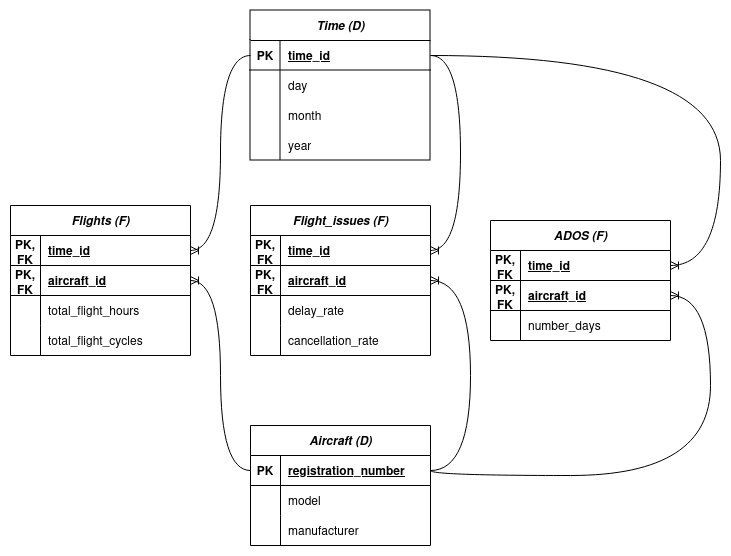

The relational algebra queries that implement the user requirements are the following (where we assume that the user wants to know the possible combinations of attributes from low granularity to high granularity, and thus **we apply the ROLLUP operator in all queries**):
1. **Total flight hours and flight cycles per aircraft, model, day, month and year**. We group the results by the rollup of (year, month, day) and (model_manufacturer, aircraft_id):

$$
A := ROLLUP\Big( 
    \big(
        \text{year, month, day, model, manufacturer, aircraft\_id,} \\
        \text{SUM(total\_flight\_hours) → total\_flight\_hours),} \\
        \text{SUM(total\_flight\_cycles) → total\_flight\_cycles}
    \big),\\
    (\text{Flights} \bowtie \text{Aircraft} \bowtie \text{Time}), \\
    (\text{year, month, day}), \\
    (\text{model, manufacturer, aircraft\_id})
\Big)
$$

2. **Delay rate, cancellation rate and aircraft days out of service per aircraft, model, month and year**.
$$B:= ROLLUP\Big( 
    \big(
        \text{year, month, model, manufacturer, aircraft\_id,} \\
        \text{AVG(delay\_rate) → delay\_rate),} \\
        \text{AVG(cancellation\_rate) → cancellation\_rate} \\
        \text{SUM(ados) → ados}
    \big),\\
    (\text{Flight\_issues} \bowtie \text{ADOS} \bowtie \text{Aircraft} \bowtie \text{Time}), \\
    (\text{year, month}), \\
    (\text{model, manufacturer, aircraft\_id})
\Big)$$ 

# 5. ROLAP queries
See the folder `rolap_queries`, which contains the SQL queries for the requirements R1 and R2 and implement the relational algebra queries shown above. In this section, we implement the queries and show the results in data frames.

## R1

In [384]:
# Open and read the query from the file
with open('rolap_queries/r1_query.sql', 'r') as file:
    Q_r1 = file.read()

# Execute the query in the data warehouse (dw)
r1_df = sqlio.read_sql_query(Q_r1, dw)

# Display the first 10 rows
r1_df.head()

model_manufacturer registration_number    year  month  day  \
0             767 Boeing              XY-AAB  2023.0    1.0  1.0   
1             737 Boeing              XY-ACY  2023.0    1.0  1.0   
2            A330 Boeing              XY-AFD  2023.0    1.0  1.0   
3  A320neo family Boeing              XY-AGF  2023.0    1.0  1.0   
4            A330 Boeing              XY-ALX  2023.0    1.0  1.0   

   total_flight_hours  total_flight_cycles  
0                5.99                  1.0  
1                0.65                  NaN  
2                1.00                  1.0  
3                8.00                  3.0  
4                1.00                  1.0

## R2

In [385]:
# Open and read the query from the file
with open('rolap_queries/r2_query.sql', 'r') as file:
    Q_r2 = file.read()

# Execute the query in the data warehouse (dw)
r2_df = sqlio.read_sql_query(Q_r2, dw)

# Display the first 10 rows
r2_df.head()

model_manufacturer registration_number    year  month  delay_rate  \
0             767 Boeing              XY-AAB  2023.0    1.0    0.046512   
1             737 Boeing              XY-ACY  2023.0    1.0    0.065217   
2            A330 Boeing              XY-AFD  2023.0    1.0    0.027027   
3  A320neo family Boeing              XY-AGF  2023.0    1.0    0.069767   
4            A330 Boeing              XY-ALX  2023.0    1.0    0.102041   

   cancellation_rate  total_ados  
0           0.023256        2.25  
1           0.152174        2.67  
2           0.027027        2.21  
3           0.046512        2.28  
4           0.081633        2.58

# 6. Closing the connection with the data warehouse

In [386]:
dw.close()